# Coronavirus (COVID-19)
"From World Health Organization - On 31 December 2019, WHO was alerted to several cases of pneumonia in Wuhan City, Hubei Province of China. The virus did not match any other known virus. This raised concern because when a virus is new, we do not know how it affects people.

2019 Novel Coronavirus (2019-nCoV) is a virus (more specifically, a coronavirus) identified as the cause of an outbreak of respiratory illness first detected in Wuhan, China. Early on, many of the patients in the outbreak in Wuhan, China reportedly had some link to a large seafood and animal market, suggesting animal-to-person spread. However, a growing number of patients reportedly have not had exposure to animal markets, indicating person-to-person spread is occurring. At this time, it’s unclear how easily or sustainably this virus is spreading between people."

(Source: https://research.binus.ac.id/2020/03/data-source-recommendation-novel-coronavirus-2019-dataset/_)

# Data Source of Data

This dataset has daily level information on the number of affected cases, deaths and recovery from 2019 novel coronavirus.

6 csv files related to historic confirmed cases, deaths, and recovered rates was obtained from: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/version/151

1 csv file related to historic vaccination rates was obtained from: https://ourworldindata.org/covid-vaccinations

# Reserch Objectives

1) The simplest objective would be to minimize the worldwide confirmed case in six months or to reduce the death rate of a particular region. 

2) For the purpose of back-testing, using only data from the year 2020, can we predict the number of confirmed cases for any particular location, for March 31st, 2021? How accurate is the prediction?

# Research Questions 

We have a million doses of COVID-19 vaccines. How should we use it? We would like our decision to be based on data.

1) Re-work to show the the best method to distribute 1M doses of COVID vaccine. 2) Could we make a prediction knowing that COVID numbers are non-stationary?

In [11]:
import random


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
from statsmodels.tsa.stattools import adfuller,  acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.linear_model import LinearRegression

# set figure shape
sns.set(rc={'figure.figsize':(13,5)})

# handle depreciated ARMA warnings
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)



In [12]:
WorldWideData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/covid_19_data.csv")
ConfirmedUsData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/time_series_covid_19_confirmed_US.csv")
RecoveredData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/time_series_covid_19_recovered.csv")
vaccinationData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/owid-covid-data.csv")
deathsData= pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/time_series_covid_19_deaths.csv")
deathsUsData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/time_series_covid_19_deaths_US.csv")
confirmedData = pd.read_csv("C:/Users/Cody/Desktop/COVID19Files/time_series_covid_19_confirmed.csv")

# Research Objective 1: Visualization of Variables
For the purpose of this study, we must decide whether to use a wide approach to deliver vaccinations across several countries or to focus on a specific site. While one million vaccinations is a huge number, it may have minimal impact if not directed at a specific country or region. Based on population density, we predict how many vaccinations each country will get. It seems doubtful that the fact that the majority of countries (121) will get less than 1,000 immunizations would make a difference. Due to population density, large countries would receive the bulk of immunizations, but the effect would be minimal. China (1,439,323,774 people) would only get 184,651 vaccinations, or 0.0001% of the population.

In conclusion, through data visualisation it was shown that if one million vaccines were distributed worldwide, they would be ineffective. Creating a tailored plan would be even more important.

In [13]:
# Get population of all countries
pop_count_by_country = dict(vaccinationData.groupby("location").agg("population").mean())
world_pop = pop_count_by_country["World"]

# Remove Continents and Missing Data
for continent in {"North America", "South America", "Asia", "Europe", "European Union", "Africa", "World"}:
    pop_count_by_country.pop(continent)
    
nan_keys = []
for key, val in pop_count_by_country.items():
    if np.isnan(val):
        nan_keys.append(key)
for nan_key in nan_keys:
    pop_count_by_country.pop(nan_key)
    
# Calculate % of World Population by Country
pop_density_by_country = {key: val/world_pop for key, val in pop_count_by_country.items()}

# Calculate total vaccines received per country
vaccine_count_by_country = {key: int(val*1000000) for key, val in pop_density_by_country.items()}
vaccine_count_df = pd.DataFrame([list(vaccine_count_by_country), list(vaccine_count_by_country.values())]).T
vaccine_count_df.columns = ["Country", "Vaccines"]
vaccine_count_df
# Display
ax = sns.histplot(data=vaccine_count_df, x="Vaccines").set_title("Vaccine Distribution Histogram")

AttributeError: module 'seaborn' has no attribute 'histplot'

In [14]:
WorldWideData.isnull().any(axis=0)
WorldWideData.dropna(inplace=True)
WorldWideData.isnull().any()
WorldWideData.loc[WorldWideData['Confirmed'] < 0]
WorldWideData=WorldWideData[~(WorldWideData['Confirmed'] <  0)]
WorldWideData['Confirmed'] = WorldWideData['Confirmed'].astype('int32')
WorldWideData['Country/Region'] = WorldWideData['Country/Region'].astype('string')

In [15]:
m  =pd.DataFrame(WorldWideData.groupby(['Country/Region']).sum()['Confirmed'])
m

Confirmed
Country/Region              
Australia       9.447430e+06
Austria         2.000000e+00
Belgium         1.547341e+08
Brazil          2.649295e+09
Canada          1.934975e+08
Chile           2.315812e+08
China           0.000000e+00
Colombia        5.151198e+08
Denmark         2.122260e+05
France          1.918464e+07
Germany         5.174361e+08
Hong Kong       2.655935e+06
India           3.221090e+09
Iraq            0.000000e+00
Israel          5.000000e+00
Italy           6.277543e+08
Japan           8.866606e+07
Lebanon         1.000000e+00
Macau           2.060500e+04
Mainland China  4.082260e+07
Mexico          4.595573e+08
Netherlands     2.304008e+08
Others          2.622800e+04
Pakistan        1.632456e+08
Peru            3.584896e+08
Russia          9.211500e+08
Spain           6.401320e+08
Sweden          1.407718e+08
Taiwan          1.104000e+03
UK              7.705376e+08
US              6.049146e+09
Ukraine         3.102261e+08

AttributeError: module 'seaborn' has no attribute 'set_theme'

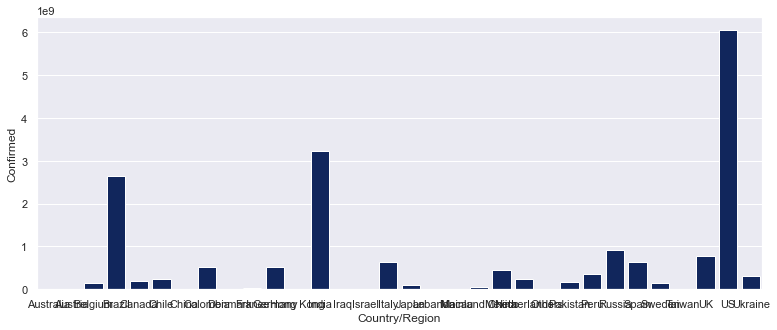

In [16]:
import seaborn 
import matplotlib.pyplot as plt
sns.barplot(x=m.index, y= m.Confirmed, data=pd.melt(m), color='#042069')
sns.set(rc={"figure.figsize":(4, 10)})
sns.set_theme(style='whitegrid')
plt.xticks(rotation=90)
plt.xlabel('Countries', size=14)
plt.ylabel('No. of confirmed corona cases', size=14)
plt.show()

In [17]:
df_list = [confirmedData,deathsData,RecoveredData]
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']
case_color = ['orange','red','green','blue']
case_dict = {cases[i]:case_color[i] for i in range(len(cases))}

In [18]:
## creating time series data

time_series_data = pd.DataFrame()
for i in range(len(cases)-1):
    df =  pd.DataFrame(df_list[i][df_list[i].columns[4:]].sum(),columns=[cases[i]])
    time_series_data = pd.concat([time_series_data,df],axis = 1)
time_series_data.index = pd.to_datetime(time_series_data.index,format='%m/%d/%y')
time_series_data['Active'] = time_series_data['Confirmed'] - time_series_data['Deaths'] - time_series_data['Recovered']
time_series_data= time_series_data.rename_axis('ObservationDate').reset_index()

In [19]:
count_df = time_series_data.iloc[1,1:]
count_df = pd.DataFrame(count_df).reset_index(level = 0).rename(columns = {'index':'category',1:'count'})
fig = px.bar(count_df, x='count', y='category',
             hover_data=['count'], color='count',
             labels={}, orientation='h',height=400, width = 650)
fig.update_layout(title_text='<b>Confirmed vs Recovered vs Deaths vs Active</b>',title_x=0.5,showlegend = False) 
fig.show()

In [20]:
country_wise_data = pd.DataFrame()
for i in range(len(cases)-1):
    series =  df_list[i][df_list[i].columns[4:]].sum(axis = 1)
    df = pd.concat([df_list[i]['Country/Region'] ,series],axis = 1)
    df = df.groupby('Country/Region').sum().rename(columns = {0:cases[i]})
    country_wise_data = pd.concat([country_wise_data,df],axis = 1)
country_wise_data['Active'] = country_wise_data['Confirmed'] - country_wise_data['Deaths'] - country_wise_data['Recovered']
country_wise_data = country_wise_data.reset_index()

In [21]:
country_wise_data.head(10).style.background_gradient(cmap='PuBu')

In [22]:
country_wise_data = country_wise_data.sort_values(by='Confirmed',ascending=False).reset_index(drop = True)
country_wise_data.head(10).style.background_gradient(cmap='Oranges',subset=["Confirmed"])\
.background_gradient(cmap='Reds',subset=['Deaths'])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Blues',subset=["Active"])

In [23]:
#Displaying dates where confirmed case counts were highest
time_series_data = time_series_data.sort_values('ObservationDate', ascending=False).reset_index(drop = True)
time_series_data.head(10).style.background_gradient(cmap='Oranges',subset=["Confirmed"])\
.background_gradient(cmap='Reds',subset=['Deaths'])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Blues',subset=["Active"])

In [24]:
time_series_data['Recovered'] = time_series_data['Recovered'].replace(to_replace=0, method='bfill')
time_series_data.head(10).style.background_gradient(cmap='Oranges',subset=["Confirmed"])\
.background_gradient(cmap='Reds',subset=['Deaths'])\
.background_gradient(cmap='Greens',subset=["Recovered"])\
.background_gradient(cmap='Blues',subset=["Active"])

In [25]:
df_confirmed = country_wise_data.loc[:,['Country/Region','Confirmed']].sort_values(by = 'Confirmed',ascending = False).reset_index(drop = True).head(10)
df_deaths =    country_wise_data.loc[:,['Country/Region','Deaths']].sort_values(by = 'Deaths',ascending = False).reset_index(drop = True).head(10)
df_active =    country_wise_data.loc[:,['Country/Region','Active']].sort_values(by = 'Active',ascending = False).reset_index(drop = True).head(10)
df_recovered =    country_wise_data.loc[:,['Country/Region','Recovered']].sort_values(by = 'Recovered',ascending = False).reset_index(drop = True).head(10)

In [26]:
fig = px.bar(df_confirmed, x='Confirmed', y='Country/Region',
             hover_data=['Confirmed'], color='Confirmed',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='<b>Total number of Confirmed cases</b>',title_x=0.5)
fig.show()

In [27]:
fig = px.bar(df_deaths, x='Deaths', y='Country/Region',
             hover_data=['Deaths'], color='Deaths',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='<b>Total number of Death cases</b>',title_x=0.5)
fig.show()

In [28]:
fig = px.bar(df_active, x='Active', y='Country/Region',
             hover_data=['Active'], color='Active',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='<b>Total number of Active cases</b>',title_x=0.5)
fig.show()

In [29]:
fig = px.bar(df_recovered, x='Recovered', y='Country/Region',
             hover_data=['Recovered'], color='Recovered',
             labels={},orientation='h', height=800, width=650)
fig.update_layout(title_text='<b>Total number of Recovered cases</b>',title_x=0.5)
fig.show()

In [30]:
#cases_over_time moving average
time_series_data_avg = time_series_data.copy()
time_series_data_avg.iloc[:,1:] = time_series_data_avg.iloc[:,1:].rolling(window = 7, min_periods = 1).mean()
time_series_data_avg.head(20)

ObservationDate     Confirmed        Deaths     Recovered        Active
0       2021-05-29  1.699516e+08  3.533619e+06  1.071407e+08  5.927727e+07
1       2021-05-28  1.697111e+08  3.528368e+06  1.068869e+08  5.929591e+07
2       2021-05-27  1.694644e+08  3.522678e+06  1.066173e+08  5.932440e+07
3       2021-05-26  1.692024e+08  3.516644e+06  1.063081e+08  5.937758e+07
4       2021-05-25  1.689315e+08  3.510473e+06  1.060115e+08  5.940956e+07
5       2021-05-24  1.686623e+08  3.504234e+06  1.057176e+08  5.944054e+07
6       2021-05-23  1.684052e+08  3.498516e+06  1.054180e+08  5.948869e+07
7       2021-05-22  1.678958e+08  3.487236e+06  1.048433e+08  5.956523e+07
8       2021-05-21  1.673726e+08  3.475836e+06  1.042531e+08  5.964362e+07
9       2021-05-20  1.668314e+08  3.464299e+06  1.036544e+08  5.971271e+07
10      2021-05-19  1.663294e+08  3.452759e+06  1.030643e+08  5.981242e+07
11      2021-05-18  1.658128e+08  3.441135e+06  1.024538e+08  5.991783e+07
12      2021-05-17  1.652833e+08  3.429297e+06  1.018197e+08  6.003427e+07
13      2021-05-16  1.647415e+08  3.417199e+06  1.011689e+08  6.015546e+07
14      2021-05-15  1.641895e+08  3.405024e+06  1.004944e+08  6.029006e+07
15      2021-05-14  1.636304e+08  3.392805e+06  9.981627e+07  6.042129e+07
16      2021-05-13  1.630581e+08  3.380536e+06  9.913090e+07  6.054662e+07
17      2021-05-12  1.624220e+08  3.368215e+06  9.843790e+07  6.061593e+07
18      2021-05-11  1.617733e+08  3.355809e+06  9.775211e+07  6.066541e+07
19      2021-05-10  1.611080e+08  3.343493e+06  9.706519e+07  6.069931e+07

# Selection of Country
Natural immunity occurs when a large portion of a community acquires immunity to a disease, protecting others who do not. For example, if four out of every five persons who come in contact with someone who has an infectious disease are resistant to it, the disease's transmission is greatly decreased. The proportion of individuals who must be immune in order to get herd immunity, on the other hand, varies depending on a variety of circumstances, including the mode of transmission and the rate at which a disease spreads. Without adequate vaccination, herd immunity cannot be acquired in the majority of instances. If permanent immunity is developed, the percentage of the population that must be infected for COVID-19 to build herd immunity is predicted to be between 70% and 90% (source: https://www.lung.org/blog/understanding-covid-herd-immunity).

If we had one million vaccines, the ideal country would have a population of 1,111,000 to 1828000 people. After all of the immunizations have been administered, the population will have gained herd immunity. The nations that have a chance of succeeding are listed below.

In [31]:
import plotly.graph_objs as go

tplot = go.Figure()
for case in cases:
    tplot.add_trace(
        go.Scatter(
            x = time_series_data['ObservationDate'],
            y = time_series_data[case],
            name = case,
            line = dict(color=case_dict[case]),
            hovertemplate ='<br><b>Date</b>: %{x}'+'<br><b>Count</b>: %{y}',
        )
    )
for case in cases:
    tplot.add_trace(
        go.Scatter(
            x = time_series_data_avg['ObservationDate'],
            y = time_series_data_avg[case],
            name = case + " 7-day moving average",
            line = dict(dash = 'dash',color=case_dict[case]),
            hovertemplate ='<br><b>Date</b>: %{x}'+'<br><b>Moving Average Count</b>: %{y}',
            showlegend = False
        )
    )

tplot.update_layout(
    updatemenus=[
        dict(
        buttons=list(
            [dict(label = 'All Cases',
                  method = 'update',
                  args = [{'visible': [True, True, True, True, True, True, True, True]},
                          {'title': 'All Cases',
                           'showlegend':True}]),
             dict(label = 'Confirmed',
                  method = 'update',
                  args = [{'visible': [True, False, False, False, True, False, False, False]},
                          {'title': 'Confirmed',
                           'showlegend':True}]),
             dict(label = 'Active',
                  method = 'update',
                  args = [{'visible': [False, False, False, True, False, False, False, True]},
                          {'title': 'Active',
                           'showlegend':True}]),
             dict(label = 'Recovered',
                  method = 'update',
                  args = [{'visible': [False, False, True, False, False, False, True, False]},
                          {'title': 'Recovered',
                           'showlegend':True}]),
             dict(label = 'Deaths',
                  method = 'update',
                  args = [{'visible': [False, True, False, False, False, True, False, False]},
                          {'title': 'Deaths',
                           'showlegend':True}]),
            ]),type = 'buttons',
             direction="right",
             showactive = True,
             x=-0.25,
             xanchor="left",
             y=1.25,
             yanchor="top"
        ),
        dict(
        buttons=list(
            [dict(label = 'Linear Scale',
                  method = 'relayout',
                  args = [{'yaxis': {'type': 'linear'}},
                          {'title': 'All Cases',
                           'showlegend':True}]),
             dict(label = 'Log Scale',
                  method = 'relayout',
                  args = [{'yaxis': {'type': 'log'}},
                          {'title': 'All Cases',
                           'showlegend':True}]),
            ]),
             direction="right",
             x=-0.25,
             xanchor="left",
             y=1.39,
             yanchor="top"
        )
    ])

tplot.update_layout(
    height=600, width=1100, 
    title_text="<b>Global cases over time</b>", title_x=0.5, title_font_size=20,
                            legend=dict(orientation='h',yanchor='top',y=1.15,xanchor='right',x=1), paper_bgcolor="snow",
                            xaxis_title="Observation Date", yaxis_title="Number of Cases")
tplot.show()


In [32]:
populationData = pd.DataFrame([list(pop_count_by_country), list(pop_count_by_country.values())]).T
populationData.columns = ["Country", "Population"]


variableCountriesData = populationData.loc[

  (populationData["Population"] >1111000) & (populationData["Population"] <  1828000)
   
]
variableCountries = list(variableCountriesData["Country"])
# handle name variants
variableCountries.append("Timor-Leste")
variableCountries.remove("Timor")
variableCountriesData


Country   Population
14               Bahrain   1.7483e+06
61     Equatorial Guinea  1.44989e+06
63               Estonia  1.32519e+06
64              Eswatini  1.17237e+06
107               Kosovo  1.78212e+06
130            Mauritius  1.27343e+06
202                Timor  1.34388e+06
206  Trinidad and Tobago  1.40337e+06

In [33]:
def format_timeseries_mydata(mydata, variableCountries):
    """ Takes a dataframe and a list of viable countries. Formats the data such that each country has its own
    column and a date column exists."""
    
    mydata = mydata.loc[(mydata["Country/Region"].isin(variableCountries))].copy()
    mydata.drop(["Province/State", "Lat", "Long"], axis=1, inplace=True)
    mydata.set_index("Country/Region", inplace=True)
    mydata = mydata.T
    mydata.reset_index(inplace=True)
    mydata.rename(columns={"index": "Date"}, inplace = True)
    mydata["Date"] = pd.to_datetime(mydata["Date"])
    mydata.sort_values("Date", inplace=True, ascending=True)
    
    return mydata

def convert_to_non_cumulative_mydata(mydata, column_name):
    """Takes a dataframe with a date column and a metric column. Converts the metric column to daily counts
    rather than cumulative values."""
    
    mydata.sort_values("Date", inplace=True, ascending=True)
    mydata['Lag'] = mydata[column_name].shift(1).fillna(0)
    mydata[f"{column_name} Daily"] = mydata[column_name] - mydata["Lag"]
    
    return mydata

In [34]:
vc_confirmed_mydata = format_timeseries_mydata(mydata=confirmedData, variableCountries=variableCountries)
vc_deaths_mydata = format_timeseries_mydata(mydata=deathsData, variableCountries=variableCountries)
vc_recovered_mydata = format_timeseries_mydata(mydata=RecoveredData, variableCountries=variableCountries)

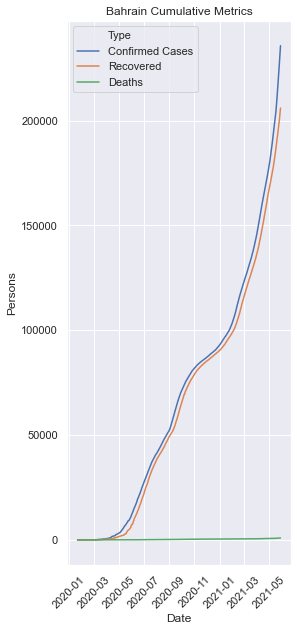

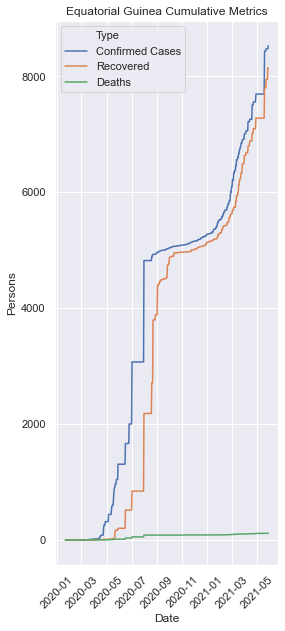

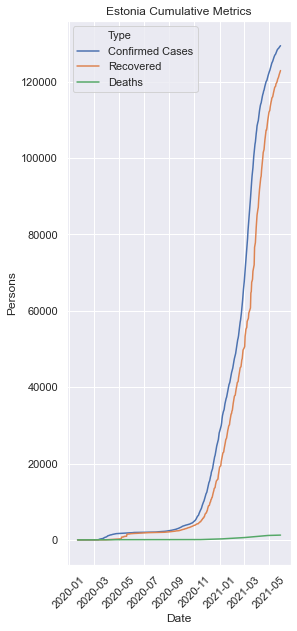

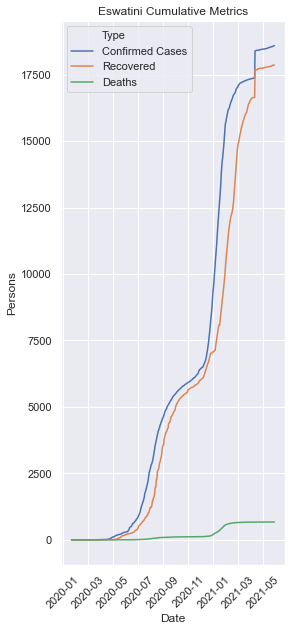

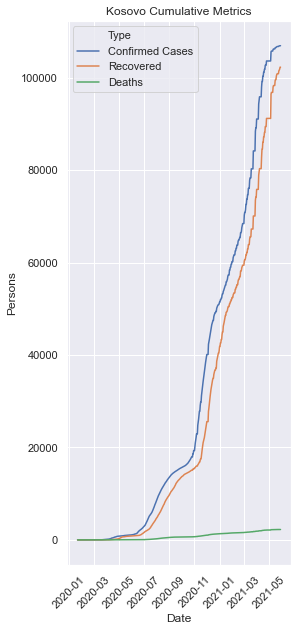

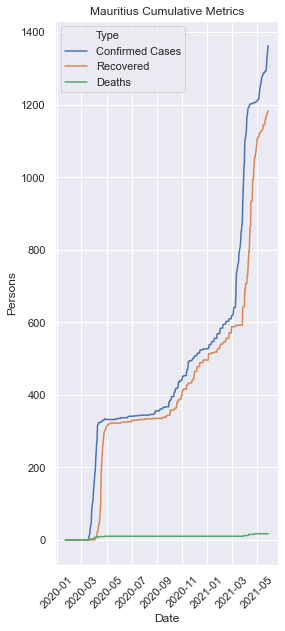

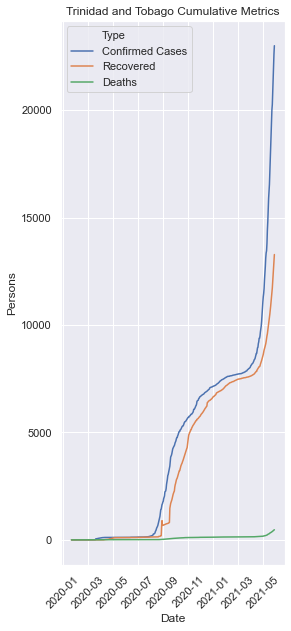

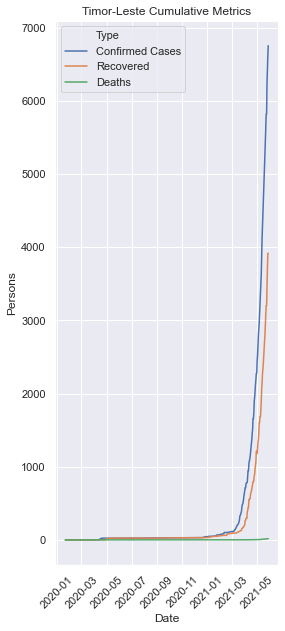

In [35]:
for country in variableCountries:
    merged_data = []
    for mydata, data_type in [
        (vc_confirmed_mydata, "Confirmed Cases"), (vc_recovered_mydata, "Recovered"), (vc_deaths_mydata, "Deaths")
    ]:
        for row in mydata[["Date", country]].iterrows():
            merged_data.append(
                {
                    "Date": row[1]["Date"],
                    "Val": row[1][country],
                    "Type": data_type
                }
            )

    country_data = pd.DataFrame(merged_data)
    ax = sns.lineplot(data=country_data, x="Date", y="Val", hue="Type")
    ax.set(xlabel='Date', ylabel='Persons', title=f"{country} Cumulative Metrics")
    ax.tick_params(axis='x', rotation=45)
    plt.show()

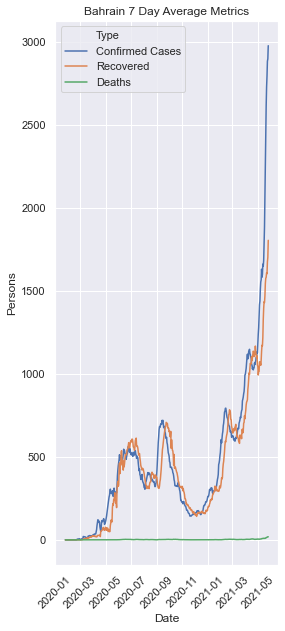

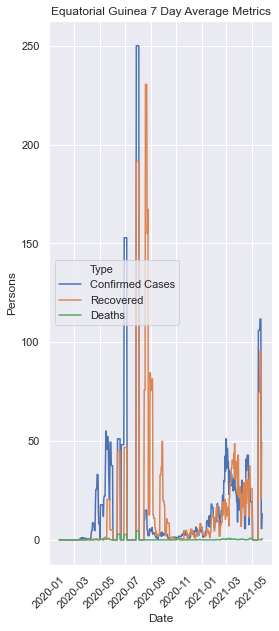

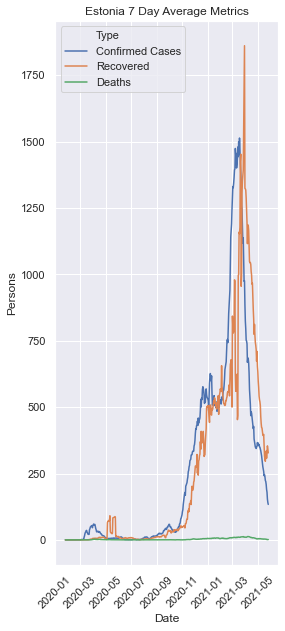

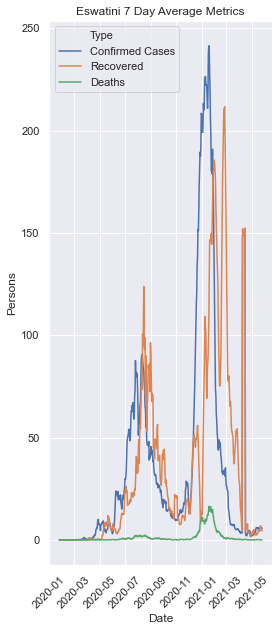

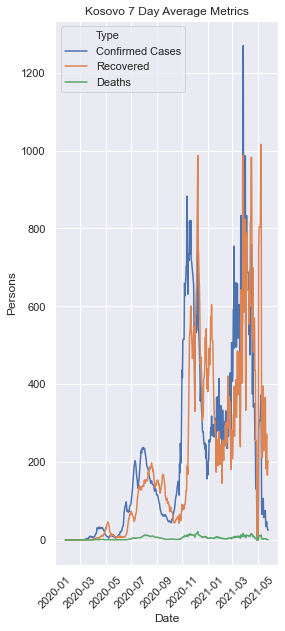

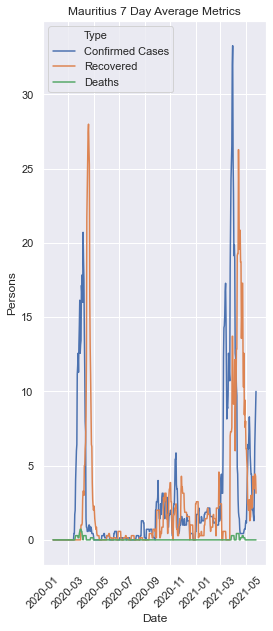

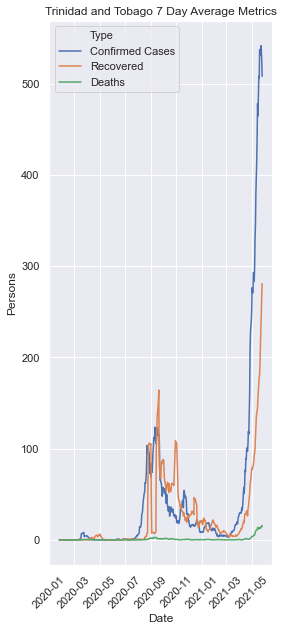

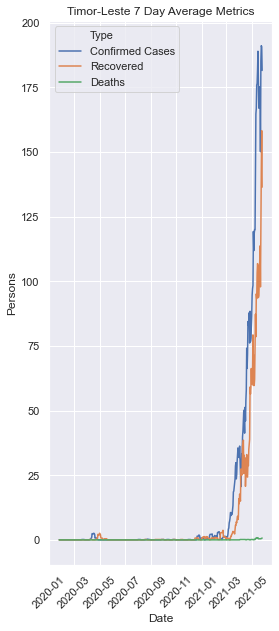

In [36]:
for country in variableCountries:
    merged_data = []
    
    vc_confirmed_mydata = convert_to_non_cumulative_mydata(mydata=vc_confirmed_mydata, column_name=country)
    vc_deaths_mydata = convert_to_non_cumulative_mydata(mydata=vc_deaths_mydata, column_name=country)
    vc_recovered_mydata = convert_to_non_cumulative_mydata(mydata=vc_recovered_mydata, column_name=country)

    for mydata, data_type in [
        (vc_confirmed_mydata, "Confirmed Cases"), (vc_recovered_mydata, "Recovered"), (vc_deaths_mydata, "Deaths")
    ]:       
        for row in mydata[["Date", f"{country} Daily"]].iterrows():
            if row[1][f"{country} Daily"] >= 0:
                merged_data.append(
                    {
                        "Date": row[1]["Date"],
                        "Val": row[1][f"{country} Daily"],
                        "Type": data_type
                    }
                )

    CountryData = pd.DataFrame(merged_data)

    # Convert to 7 day rolling average
    ccAverage = CountryData.loc[(CountryData["Type"] == "Confirmed Cases")].copy()
    ccAverage['rolling_avg'] = ccAverage.Val.rolling(7).mean().shift(-3)

    rAverage = CountryData.loc[(CountryData["Type"] == "Recovered")].copy()
    rAverage['rolling_avg'] = rAverage.Val.rolling(7).mean().shift(-3)

    dAverage = CountryData.loc[(CountryData["Type"] == "Deaths")].copy()
    dAverage['rolling_avg'] = dAverage.Val.rolling(7).mean().shift(-3)

    CountryData = pd.concat([ccAverage, rAverage, dAverage])
    CountryData.dropna(inplace=True)


    ax = sns.lineplot(data=CountryData, x="Date", y="rolling_avg", hue="Type")
    ax.set(xlabel='Date', ylabel='Persons', title=f"{country} 7 Day Average Metrics")
    ax.tick_params(axis='x', rotation=45)
    plt.show()


In [37]:
country = "Bahrain"
merged_data = {}
    
vc_confirmed_mydata = convert_to_non_cumulative_mydata(mydata=vc_confirmed_mydata, column_name=country)
vc_deaths_mydata = convert_to_non_cumulative_mydata(mydata=vc_deaths_mydata, column_name=country)
vc_recovered_mydata = convert_to_non_cumulative_mydata(mydata=vc_recovered_mydata, column_name=country)

for mydata, data_type in [
    (vc_confirmed_mydata, "Confirmed Cases"), (vc_recovered_mydata, "Recovered"), (vc_deaths_mydata, "Deaths")
]:       
    for row in mydata[["Date", f"{country} Daily"]].iterrows():
        if row[1][f"{country} Daily"] >= 0 and row[1]["Date"] not in merged_data:
            merged_data[row[1]["Date"]] = {
                "Date": row[1]["Date"],
                data_type: row[1][f"{country} Daily"],
            }
        else:
              merged_data[row[1]["Date"]].update(
                {
                    "Date": row[1]["Date"],
                    data_type: row[1][f"{country} Daily"],
                }
              )
            
Bahrain_mydata = pd.DataFrame(merged_data.values())

# Calculate relationship between Confirmed Cases and Recovered/Deaths
model= LinearRegression().fit( Bahrain_mydata[["Confirmed Cases"]],  Bahrain_mydata["Recovered"])
recovered_coef = model.coef_
model = LinearRegression().fit( Bahrain_mydata[["Confirmed Cases"]],  Bahrain_mydata["Deaths"])
deaths_coef = model.coef_

In [38]:
def cases_reduction(x):
    """ Estimates the reduction in confirmed cases """
    
    return int(x["Confirmed Cases"] * random.uniform(1-0.903, 1-0.976))

def recovered_reduction(x):
    """ Estimates the reduction in recovered individuals """
    
    return int(x["Confirmed Cases Post Vaccination"] * recovered_coef)

def deaths_reduction(x):
    """ Estimates the reduction in deaths """
    
    return int(x["Confirmed Cases Post Vaccination"] * deaths_coef)
    
Bahrain_mydata["Confirmed Cases Post Vaccination"] = Bahrain_mydata.apply(lambda x: cases_reduction(x), axis=1)
Bahrain_mydata["Recovered Post Vaccination"] = Bahrain_mydata.apply(lambda x: recovered_reduction(x), axis=1)
Bahrain_mydata["Deaths Post Vaccination"] = Bahrain_mydata.apply(lambda x: deaths_reduction(x), axis=1)

In [39]:
Bahrain_hue = []
vaccine_date = pd.to_datetime("2021-01-01")
for row in Bahrain_mydata.iterrows():
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Projected Confirmed Cases",
            "Val": row[1]["Confirmed Cases Post Vaccination"] if row[1]["Date"] > vaccine_date  else row[1]["Confirmed Cases"]
        }
    )
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Projected Recovered",
            "Val": row[1]["Recovered Post Vaccination"] if row[1]["Date"] >vaccine_date else row[1]["Recovered"],
        }
    )
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Projected Deaths",
            "Val": row[1]["Deaths Post Vaccination"] if row[1]["Date"] > vaccine_date else row[1]["Deaths"],
        }
    )
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Actual Confirmed Cases",
            "Val": row[1]["Confirmed Cases"],
        }
    )
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Actual Recovered",
            "Val": row[1]["Recovered"],
        }
    )
    Bahrain_hue.append(
        {
            "Date": row[1]["Date"],
            "Type": "Actual Deaths",
            "Val": row[1]["Deaths"],
        }
    )


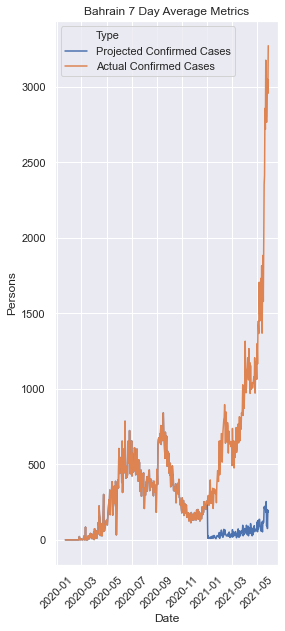

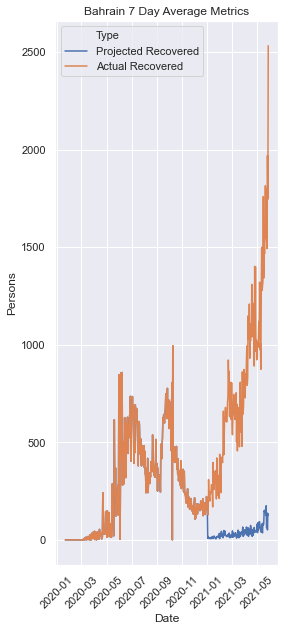

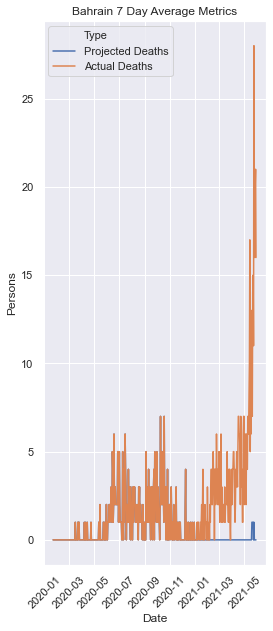

In [40]:
Bahrain_hue_df = pd.DataFrame(Bahrain_hue)

cc_compare = Bahrain_hue_df.loc[(Bahrain_hue_df["Type"].isin(["Projected Confirmed Cases", "Actual Confirmed Cases"]))]
ax = sns.lineplot(data=cc_compare, x="Date", y="Val", hue= "Type")
ax.set(xlabel='Date', ylabel='Persons', title=f"{country} 7 Day Average Metrics")
ax.tick_params(axis='x', rotation=45)
plt.show()

r_compare = Bahrain_hue_df.loc[(Bahrain_hue_df["Type"].isin(["Projected Recovered", "Actual Recovered"]))]
ax = sns.lineplot(data=r_compare, x="Date", y="Val", hue= "Type")
ax.set(xlabel='Date', ylabel='Persons', title=f"{country} 7 Day Average Metrics")
ax.tick_params(axis='x', rotation=45)
plt.show()

d_compare = Bahrain_hue_df.loc[(Bahrain_hue_df["Type"].isin(["Projected Deaths", "Actual Deaths"]))]
ax = sns.lineplot(data=d_compare, x="Date", y="Val", hue= "Type")
ax.set(xlabel='Date', ylabel='Persons', title=f"{country} 7 Day Average Metrics")
ax.tick_params(axis='x', rotation=45)
plt.show()

# Summary
Bahrain has been deemed the best possible candidate country by the United Nations. One million vaccination doses may be administered in a short period of time, affecting a large portion of the population, due to the country's small size. With more than a million persons out of 1748295 people, the vaccinated and previously infected people' herd immunity can assist the remaining unvaccinated population, greatly lowering the risk of a recurrence following the first outbreak.

If the vaccines were made available and administered within a month of their release date (Dec. 1st 2020), the effect would be profound (Jan 1st 2021). A large wave reached Bahrain in January, resulting in a large number of verified cases (over 1000 per day). With a 95% success rate, this might have been considerably lowered.

An estimated 98,000 individuals will no longer need to be hospitalized because of this, and 1,000 people will die. Emergency department and hospitalization expenses would also be reduced dramatically. Finally, the social and societal ramifications may be lessened greatly as a result of this development. The neighborhood may be able to avoid closing businesses because of the high vaccination rate and minimal risk of subsequent outbreaks. This will help prevent the spread of soical illnesses.

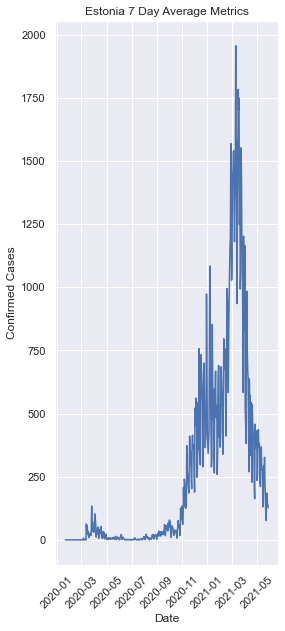

In [41]:

country = "Estonia"
country_df = format_timeseries_mydata(mydata=confirmedData, variableCountries=variableCountries)
country_daily_df =convert_to_non_cumulative_mydata(mydata=vc_confirmed_mydata, column_name=country)
country_timeseries = country_daily_df[["Date", f"{country} Daily"]].copy()
country_timeseries.sort_values("Date", inplace=True)

ax = sns.lineplot(data=country_timeseries, x="Date", y=f"{country} Daily")
ax.set(xlabel='Date', ylabel='Confirmed Cases', title=f"{country} 7 Day Average Metrics")
ax.tick_params(axis='x', rotation=45)
plt.show()

# Stationary
A timeseries is termed stationary if statistical properties such as mean and variance remain constant across time. The bulk of timeseries models make the assumption that the TS is stationary. Intuitively, we may say that if a timeseries demonstrates a given pattern across time, there is a high likelihood that it will continue to do so in the future. Furthermore, stationary series theories are more established and easier to implement than non-stationary series theories.

The series is considered to be stationary if its statistical properties, such as the following, stay constant across time: a consistent average,Variability is continuous,a non-time dependent autocovariance.

In [42]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).mean().std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

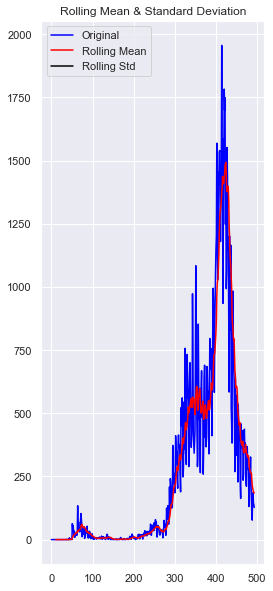

Results of Dickey-Fuller Test:
Test Statistic                  -2.560650
p-value                          0.101406
#Lags Used                      15.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


In [43]:
ts_df = country_timeseries[f"{country} Daily"]
test_stationarity(ts_df)

The test statistic is greater than the critical values, so we reject the null hypothesis and conclude that the series is not stationary. In this approach, we take the difference between the observation at one instant and the observation at the previous instant. 

C:\Users\Cody\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning:

divide by zero encountered in log



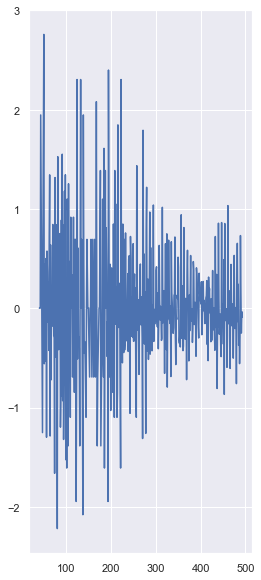

In [44]:
ts_log = np.log(ts_df)
ts_log.replace([np.inf, -np.inf], np.nan, inplace=True)
ts_log.dropna(inplace=True)

ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

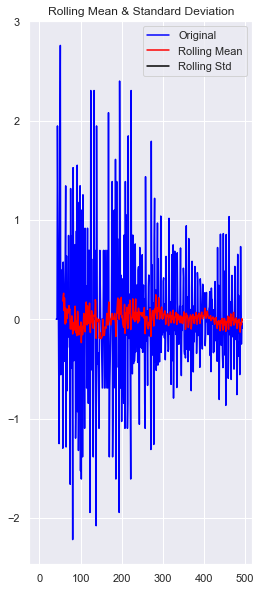

Results of Dickey-Fuller Test:
Test Statistic                  -5.594536
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    418.000000
Critical Value (1%)             -3.446091
Critical Value (5%)             -2.868479
Critical Value (10%)            -2.570466
dtype: float64


In [45]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# ARIMA Model

In [46]:
lag_acf = acf(ts_log_diff, nlags=20, fft=False)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

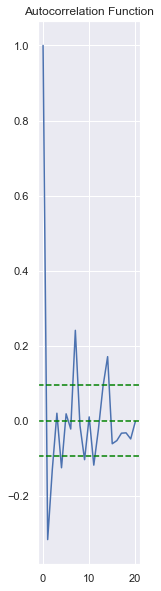

In [47]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

The confidence interevals are represented by the two dotted lines on either side of 0. The 'p' and 'q' values can be calculated using the following formulas:

p – The lag value at which the PACF chart passes the upper confidence interval for the first time. If you look closely, you'll notice that p=1 in this case.

q – The lag value at which the ACF chart reaches the upper confidence interval for the first time. If you look attentively, you'll discover that q=1 in this situation.

Let's create an ARIMA model that considers both individual and cumulative effects.

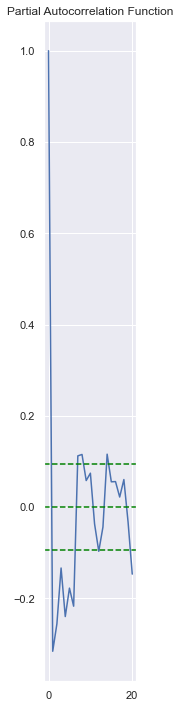

In [48]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Cody\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\Cody\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: nan')

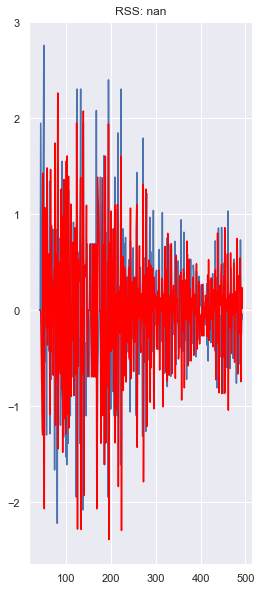

In [49]:
model = ARIMA(ts_log, order=(0,2, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [50]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

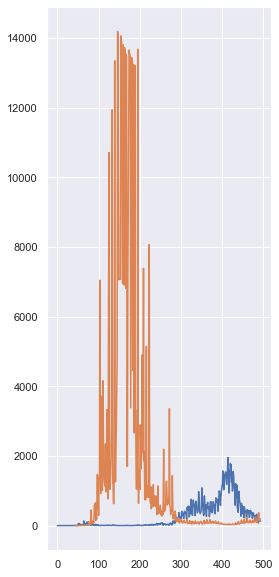

In [51]:
predictions_ARIMA = np.exp(predictions_ARIMA_diff_cumsum)
plt.plot(country_timeseries[f"{country} Daily"])
plt.plot(predictions_ARIMA)

# Summary
Our projections were not accurate. After correcting for seasonality and developing a stationary function, we are unable to confidently anticipate confirmed cases until 2021. There are a number of factors that contribute to this. While our data appears to be clean in isolation, there are a lot of underlying concerns that we haven't addressed. Each country approaches COVID-19 in a unique way. A number of government mandates restrict data collecting. Lockdowns, mask rules, border closures, behavioral/social inclinations, temperature fluctuations, and COVID-19 variances are all in play. We may have had better luck calculating total numbers, but daily values are more crucial.

In the future, we'd like to add more data sources pertaining to some of the factors mentioned above to determine whether we can account for all of these external consequences.